# Purpose

This notebook is to test whether the `neuro_op` module's nodes can successfully infer `world_dist` if only this distribution's information pieces $x_{world}$ are received (i.e., with rates h>0, r=0).

For this, the model is run with nodes receiving different amount of information (i.e., different `t_max`, `h`). Then, each node's posterior predictive distribution (*PPD*), equalling its forecast of future incoming information, is obtained via 
1. sampling of model parameters $\theta$ proportional to its posterior $p(\theta | x_{world})$;
2. using these sampled model parameters to generate data proportional to the model likelihood $p(x_{PPD}|\theta_{sampled})$

PPDs thereby fully conserves uncertainty by paying respect to both posterior and likelihood stochasticity.

We then use the PPDs to quantify the nodes' modelling accuracy by computing the Kullback-Leibler divergence and average MLE distances between node PPDs and data generated by `world_dist`.

In [29]:
# import cProfile
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

import neuro_op as nop

In [53]:
# Reference input
input = dict(
    G=nop.build_random_network(N_nodes=100, N_neighbours=5),  # networkx graph object
    llf_nodes=st.norm,  # Likelihood function (llf) of nodes, Gaussian by default
    llf_world=st.norm,  # Likelihood function (llf) of world, Gaussian by default
    params_node=dict(  # Parameter priors of nodes (mu and associated uncertainty (standard deviation)), Gaussian by default
        loc=2,
        scale=1,
    ),
    sd_llf=1,  # Standard deviation of the likelihood function (llf) of nodes, assumed known & static
    params_world=dict(  # Likelihood function (llf) parameters of world, Gaussian by default
        loc=0,
        scale=1,
    ),
    h=1,  # Rate of external information draw events
    r=0,  # Rate of edge information exchange events
    t0=0,  # Start time of simulation
    t_max=50,  # End time of simulation
    t_sample=.5,  # Periodicity for which samples and distance measures (KL-div, p-distance) are taken
    sample_bins=201,  # Number of bins used in distance measures
    sample_range=(
        -5,
        5,
    ),  # Interval over which distance measure distributions are considered
    sampling=True
)

In [54]:
# Exec times (s)
# ---
# llf_instance:     13.1
# llf improved:     7.4
# rng w. params:    6.78
# rng scaled        6.93

In [55]:
# cProfile.run("nop.run_model_Param(**input)")

In [56]:
out1 = nop.run_model_Param(**input)

print(out1["N_events"])

4977


In [42]:
nop.export_hdf5(out1, "test.h5")

In [43]:
out1 = nop.import_hdf5_Grid("test.h5")

## Data analysis

Random data analysis test notebook of steps later used in thorough analysis.


In [44]:
# For improving of readability, increase all font sizes of plots. Also, set legend location to upper right.
# plt.rcParams.update(
#    {
#        "font.size": 20,
#        "legend.loc": "upper right",
#    }
# )

#### Data analysis 1

Firstly, extract output values for further analysis:

In [45]:
for i in out1.keys():
    print(i)

world
G
N_events
t_end
t_start
t_exec
seed
nodesConj
mu_nodes
kl_divs



Each node's posteriors are plotted. One should see nodes' posteriors of model parameters (in this case, $\mu$), to converge around the true value. If not, nodes may need more information to converge ($\rightarrow$ increase $t_{max}, h$).


(array([ 6.,  6.,  8.,  9., 14.,  9.,  7.,  9., 11.,  4.,  9.,  2.,  1.,
         1.,  1.,  0.,  0.,  0.,  2.,  1.]),
 array([0.06286946, 0.06618096, 0.06949246, 0.07280396, 0.07611546,
        0.07942696, 0.08273846, 0.08604996, 0.08936145, 0.09267295,
        0.09598445, 0.09929595, 0.10260745, 0.10591895, 0.10923045,
        0.11254195, 0.11585345, 0.11916495, 0.12247645, 0.12578795,
        0.12909944]),
 <BarContainer object of 20 artists>)

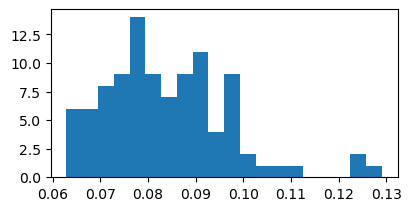

In [46]:
sigmas = []
for i in out1["nodesConj"]:
    sigmas += [i.params_node["scale"]]
fig, ax = plt.subplots(constrained_layout=True, figsize=(4, 2))
ax.hist(sigmas, bins=20)

[[ 1.39705401e+00  5.40000000e+01  2.64146416e-01]
 [ 1.99683046e-02  3.30000000e+01  8.73370738e-01]
 [ 2.87665395e-01  3.30000000e+01  1.82523668e+00]
 [ 1.31858473e+00  9.80000000e+01  1.82569374e+00]
 [-1.17468050e+00 -1.00000000e+00  2.07344165e+00]
 [-1.59429160e+00 -1.00000000e+00  2.09285956e+00]
 [ 9.52215304e-01  3.90000000e+01  2.85386137e+00]
 [ 2.30389450e-03 -1.00000000e+00  3.37477105e+00]
 [-3.22095163e-01 -1.00000000e+00  4.31559932e+00]
 [ 9.62367038e-01  3.90000000e+01  4.36142561e+00]
 [ 1.49100118e+00 -1.00000000e+00  5.42464463e+00]
 [ 6.50796620e-01 -1.00000000e+00  6.27223772e+00]
 [ 1.07926758e+00 -1.00000000e+00  6.37839519e+00]
 [-7.47562481e-01 -1.00000000e+00  6.86918785e+00]
 [ 9.60805616e-01  3.90000000e+01  6.91859070e+00]
 [ 5.56132889e-01  5.40000000e+01  6.98448814e+00]
 [ 9.64711058e-01  2.40000000e+01  7.60099168e+00]
 [ 5.89315091e-01  2.40000000e+01  7.67157302e+00]
 [-2.00170139e+00 -1.00000000e+00  8.43194817e+00]
 [ 6.27567198e-01  2.40000000e+

(array([ 1.39705401e+00,  1.99683046e-02,  2.87665395e-01,  1.31858473e+00,
        -1.17468050e+00, -1.59429160e+00,  9.52215304e-01,  2.30389450e-03,
        -3.22095163e-01,  9.62367038e-01,  1.49100118e+00,  6.50796620e-01,
         1.07926758e+00, -7.47562481e-01,  9.60805616e-01,  5.56132889e-01,
         9.64711058e-01,  5.89315091e-01, -2.00170139e+00,  6.27567198e-01,
         6.60186711e-01,  1.81032833e-01,  4.97108561e-01,  4.54702870e-01,
         6.34089748e-01, -2.94310639e-03,  1.04229265e+00,  2.71603604e-01,
         2.56113635e-01,  2.31985949e-01,  2.70922039e-01,  2.43893205e-01,
         5.15547758e-01,  7.71852895e-01,  4.19475469e-01,  7.66866119e-01,
         7.79068427e-01,  8.43350312e-01, -6.69006934e-01,  6.83168914e-01,
         5.01888675e-01,  5.65842182e-01, -2.16451783e+00,  9.06452585e-01,
        -7.53004102e-01,  3.76588547e-01, -9.10382890e-02, -2.35805999e-01,
         4.74275732e-01,  5.76742134e-01, -5.45152760e-01,  4.89625032e-01,
         2.0

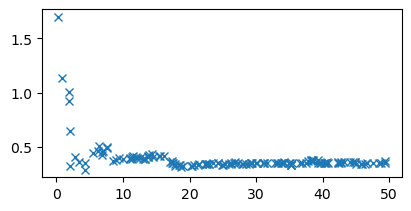

In [47]:
# Implement external sampling routine (or rather test if feasible)
k = 5
nody = out1["nodesConj"][k]
#mu_nody = np.array(out1["mu_nodes"])[:, k][1:]
#
fig, ax = plt.subplots(constrained_layout=True, figsize=(4, 2))
#ax.plot(
#    np.arange(input["t0"], input["t_max"], input["t_sample"]),
#    mu_nody,
#)

mu, sig = input["params_node"].values()
sd_llf = input["sd_llf"]
x_in = np.array(nody.diary_in)
post_mu = x_in[:, 0]
post_sig = np.zeros_like(post_mu)

i = -1
post_mu[i], post_sig[i] = mu, sig
for i, _ in enumerate(x_in):
    post_mu[i] = (post_sig[i - 1] ** 2 * x_in[i, 0] + sd_llf**2 * post_mu[i - 1]) / (
        post_sig[i - 1] ** 2 + sd_llf**2
    )
    post_sig[i] = (1 / post_sig[i - 1] ** 2 + 1 / sd_llf**2) ** (-0.5)

ax.plot(x_in[:, 2], post_mu, "x", alpha=1)

print(nody.diary_in)
nop.postrun_Mu_ConjMu(2,1,1,nody.diary_in)

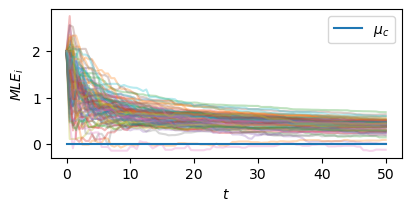

In [48]:
mu_arr = np.array(out1["mu_nodes"])
x = np.arange(input["t0"], input["t_max"] + input["t_sample"], input["t_sample"])
fig, ax = plt.subplots(constrained_layout=True, figsize=(4, 2))
for i, _ in enumerate(mu_arr.T):
    ax.plot(x, mu_arr.T[i], alpha=0.3)
    ax.set_xlabel("$t$")
    ax.set_ylabel("$MLE_i$")
# ax.set_ylim(-5, 5)
ax.plot(x, [0] * len(x), "-", label="$\mu_c$")
# ax.set_yscale("log")
# ax.loglog()
ax.legend()

#### Data analysis 2

In [37]:
N_iter = range(input["G"].number_of_nodes())
kld = np.array(out1["kl_divs"])
lin_dis = np.array(out1["p_distances"])[:, 0]
quad_dis = np.array(out1["p_distances"])[:, 1]
print(lin_dis.shape)
kld.shape
np.array(out1["p_distances"]).shape

KeyError: 'p_distances'

(100,)

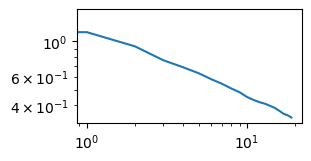

In [ ]:
# for i in N_iter:
#    plt.plot(input["t_sample"] * np.arange(0, kld.shape[0]), kld[:, i, ])
fig, ax = plt.subplots(constrained_layout=True, figsize=(3, 1.5))

i = 0
ax.plot(
    # input["t_sample"] * np.arange(0, kld.shape[0]),
    kld.mean(axis=1)[1:],
    label="avg",
)
plt.loglog()
# plt.ylim(0, 2)
kld.mean(axis=i).shape

In [ ]:
print(quad_dis.shape)
fig, ax = plt.subplots(constrained_layout=True, figsize=(4, 2))
for i in N_iter:
    ax.plot(input["t_sample"] * np.arange(1, quad_dis.shape[0]), quad_dis[1:, i])

NameError: name 'quad_dis' is not defined

In [ ]:
print(lin_dis.shape)
fig, ax = plt.subplots(constrained_layout=True, figsize=(4, 2))
for i in N_iter:
    ax.plot(input["t_sample"] * np.arange(1, lin_dis.shape[0]), lin_dis[1:, i])

NameError: name 'lin_dis' is not defined

In [ ]:
arr = np.array(out1["p_distances"])
print(arr.shape)
# (arr[-1, 0, 1, :] ** 2).mean()

KeyError: 'p_distances'